In [1]:
import matplotlib.pyplot as plt

from fitting import create_ensemble, load_data, create_datasets
import torch
from torchensemble.utils import io

labels = ["x (mm)", r"$p_x$ (mrad)","y (mm)",r"$p_y$ (mrad)","z (mm)",r"$p_z$ (mrad)"]

tkwargs = {"dtype": torch.float}
base_dir = "/global/cfs/cdirs/m669/rroussel/phase_space_reconstruction"
save_dir = base_dir + "/mse_scale_1_l_1e13"
quad_strengths, image_data, bins, xx = load_data(base_dir, tkwargs)
xx = xx.cpu()

quad_strengths = quad_strengths[:,[0,4,3],:]
image_data = image_data[:,[0,4,3],:]

train_dset = torch.load(save_dir + "/train.dset")
test_dset = torch.load(save_dir + "/test.dset")

bin_width = bins[1] - bins[0]
bandwidth = bin_width / 2
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, save_dir)

n_particles = 1000000
for ele in ensemble:
    ele.beam.set_base_beam(
        ele.beam.base_dist,
        n_particles,
        p0c=torch.tensor(63.0e6)
    )

ensemble = ensemble.cuda();



/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
def propagate_to_slits(initial_coords):
    # distances
    dist_to_slits = 3.38 - 2.84 + 0.12/2.0
    dist_to_screen = 3.38 + 0.12/2.0
    
    final_coords = initial_coords.clone()
    final_coords[:,0] = initial_coords[:,0] + initial_coords[:,1] * dist_to_slits
    final_coords[:,2] = initial_coords[:,2] + initial_coords[:,3] * dist_to_slits
    
    return final_coords
    
def get_twiss(beam_coords):
    cov = torch.cov(beam_coords.T)
    emit = torch.det(cov).sqrt()
    #print(f"geo_emit: {emit}")
    #print(f"norm emit: {emit*63.0/0.511}")

    twiss = cov / emit
    #print(f"beta {twiss[0,0]}")
    #print(f"alpha {-twiss[1,0]}")
    #print(f"gamma {twiss[1,1]}")
    
    return torch.tensor((emit*63.0/0.511, twiss[0,0], -twiss[1,0]))

tensor([ 3.4241e-06,  1.0289e+01, -1.8187e-01])
tensor([9.6053e-09, 7.7480e-02, 9.2770e-03])
0.28129431349425726


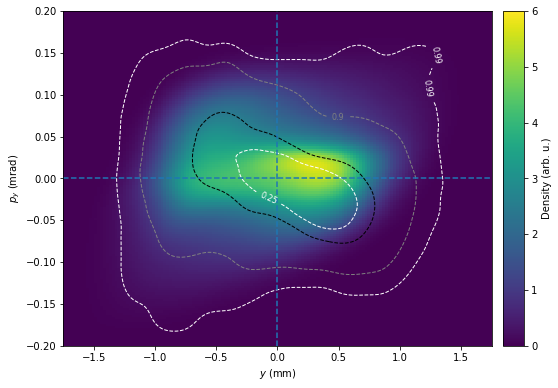

In [4]:
# compare reconstruction to slit scan measurement
import numpy as np
from scipy.ndimage import median_filter, gaussian_filter
from matplotlib.lines import Line2D

fpath = base_dir

meas_y = np.load(fpath + "/y_recon.npy")*1e3
meas_yp = np.load(fpath + "/yp_recon.npy")*1e3

fig,ax=plt.subplots(1,2,gridspec_kw={
        "right": 0.9,"hspace":0.05,"left":0.1,"top":0.925,"bottom":0.15,"wspace":0.05,
        "width_ratios":[1.0,0.05]
    })
#ax[-1].remove()

scale=1
fig.set_size_inches(np.array((4,3))*2.0)
# create a mesh
x1 = np.linspace(-1.75,1.75,150)
x2 = np.linspace(-0.2,0.2,150)


ensembles = [ensemble]
for jj in range(len(ensembles)):

    # iterate through ensemble members to get reconstruction images
    reconstruction_images = []
    twiss = []
    for i in range(2, len(ensembles[jj])):
        initial_beam = ensembles[jj][i].beam().data
        reconstruction_beam = propagate_to_slits(initial_beam)

        reconstruct_x = reconstruction_beam[:,2].detach().cpu().numpy()*1e3
        
        
        # try with slope, not p_y
        p_y = reconstruction_beam[:,3].detach().cpu().numpy()
        p_x = reconstruction_beam[:,1].detach().cpu().numpy()
        p_z = 0.0
        
        reconstruct_y = (p_y / np.sqrt(1 - p_x**2 - p_y**2))*1e3
        #reconstruct_y = reconstruction_beam[:,3].detach().cpu().numpy()*1e3

        h_reconstruction, xe, ye = np.histogram2d(reconstruct_x, reconstruct_y,
                                                  bins=[x1,x2], density=True)
        h_reconstruction = gaussian_filter(h_reconstruction, 3)

        reconstruction_images += [h_reconstruction]
        
        twiss += [get_twiss(reconstruction_beam[:,2:4])]

    reconstruction_mean = np.array(reconstruction_images).mean(axis=0)
    reconstruction_std = np.array(reconstruction_images).std(axis=0)
    
    twiss = torch.stack(twiss)
    print(twiss.mean(dim=0))
    print(twiss.std(dim=0))

    h_slitscan, _, _ = np.histogram2d(meas_y, meas_yp, bins=[x1,x2], density=True)

    # apply median filter
    h_slitscan = gaussian_filter(h_slitscan,3)
    
    # calculate agreement
    density_mse = np.mean((reconstruction_mean - h_slitscan)**2)
    print(density_mse)

    # get cdf of densities
    vmax = h_slitscan.max()
    test_levels = np.linspace(0, vmax, 1000)
    # for each level calculate the fractional sum
    total = h_slitscan.sum()

    sums = []
    for ele in test_levels:
        sums += [np.where(h_slitscan >= ele, h_slitscan, 0.0).sum() / total]
    sums = np.array(sums)

    # calculate levels
    quantiles = [0.25,0.5,0.9,0.99]
    levels = []
    for ele in quantiles[::-1]:
        diff = sums - ele
        levels += [test_levels[np.where(np.diff(np.sign(diff)))]]
    clevels = np.array(levels).flatten()
    x1c = (xe[:-1] + xe[1:]) / 2
    x2c = (ye[:-1] + ye[1:]) / 2

    X, Y = np.meshgrid(xe,ye)
    Xc, Yc = np.meshgrid(x1c,x2c)

    c1 = ax[jj].pcolor(X, Y, reconstruction_mean.T,vmin=0,vmax=6)
    #ax.contour(Xc, Yc, h_reconstruction.T,levels=3)
    c2 = ax[jj].contour(Xc, Yc, h_slitscan.T, levels=clevels,linestyles="dashed",
                        colors=["black","grey","white"][::-1],linewidths=1)

    if jj == 0:
        #custom_lines = []
        #for j in range(len(clevels)):
        #    lc = c2.collections[j].get_edgecolor()
        #    custom_lines += [Line2D([0],[0], color=lc)]
        #ax[jj].legend(custom_lines, quantiles[::-1])
        ax[jj].clabel(
                c2, inline=True, fontsize=8,
                fmt=dict(zip(clevels,[f"{ele}" for ele in quantiles[::-1]])),
                manual=[(1.5*kk/3, 0.15*kk/3) for kk in range(len(quantiles))]
            )

    #cbar = fig.colorbar(c1)
    # add ellipse
    #ax.add_patch(confidence_ellipse(ycov.cpu().detach().numpy(),1.0e3,edgecolor='red'))

    
    #ax[jj].set_aspect(5)
    ax[jj].set_xlabel(r"$y$ (mm)")
cbar = fig.colorbar(c1, cax=ax[-1],label="Density (arb. u.)")
ax[0].set_ylabel(r"$p_y$ (mrad)")
ax[0].axhline(0.0,ls='--')
ax[0].axvline(0.0,ls='--')

#ax[1].set_yticks([])

#fig.savefig(f"reconstruction_comparison_{save_dir}.png", dpi=300)